In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # sataset를 2개로 분리해서 모델1, 2에 할당
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
from datetime import datetime

# train, test loss를 graph

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [4]:
#tf.keras.backend.set_floatx('float64')

# GPU 메모리 2GB로 제한

In [5]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
#    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')    
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])    
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

In [6]:
file_name = '~/Data/kospi200f_809_0515.csv'
item_name = 'kospi200f_809_0515'
train_start = '2000-01-31'
train_end = '2017-01-02'
test_start = '2017-01-02'
test_end = '2018-12-31'

remove_columns = ['date', '종가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'loss_cut-3-test'
channel = False

trans_day = 20

target_alpha = 100
future_day = 240
train_end_back = -1
n_timestep = 30
time_interval = 20
input_size = 809
n_unit = 500
batch_size = 20
learning_rate = 0.0005
epochs = 500

alpha = 0.05
beta = 0.01

comment = "미래데이터 사용 error수정,예측 모델 MSE loss에 sharp ratior, maximumdrawdown loss 추가"

from datetime import datetime
now = datetime.now().strftime('%Y-%m-%d-%H:%M:%S')
checkpoint_path = model_name + "/pred"+str(future_day)+":"+now+".ckpt"

In [7]:

dataframe = util.read_datafile(file_name)
df = dataframe.copy()
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
a = []
b = []
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) 
                                / df.loc[i, target_column]) * target_alpha                                
    df.loc[i, '시가'] = df.loc[i + future_day + train_end_back + 1, '시가']
    a.append(max(df.loc[i  + future_day + train_end_back + 1:i + future_day + 1, '고가']))
    b.append(min(df.loc[i  + future_day + train_end_back + 1:i + future_day + 1, '저가']))
for i in range(len(df['종가']) - future_day):
    df.loc[i, '고가'] = a[i]
    df.loc[i, '저가'] = b[i]

In [8]:
df.head(20)

,date,시가지수(포인트),고가지수(포인트),저가지수(포인트),종가지수(포인트),수익률(%),수익률 (1주)(%),수익률 (1개월)(%),수익률 (3개월)(%),수익률 (6개월)(%),...,"주요상품선물_천연가스(선물, NYMEX)($/mmBtu)",주요상품선물_금(선물)($/ounce),주요상품선물_은(선물)($/ounce),주요상품선물_알루미늄(선물)($/ton),주요상품선물_옥수수(최근월물)(￠/bu),대두박(￠/bu),종가,시가,고가,저가
0,2000-01-31,-0.218225,-0.493106,-0.400439,-0.223565,0.212872,1.352924,-0.851790,-0.382658,-0.162615,...,1.653438,-0.853010,0.974513,0.827681,0.373581,0.614542,-33.653846,76.70,79.70,75.95
1,2000-02-01,-0.213200,-0.230417,-0.373954,-0.595373,-0.407635,1.808646,-1.074203,-1.707405,-0.490731,...,1.687061,-0.039689,0.193571,1.002058,0.594935,0.706918,-32.032943,77.70,79.70,76.70
2,2000-02-02,-0.208520,-0.448886,-0.367787,-0.200398,0.696677,2.107257,-0.769928,-1.558400,0.074389,...,1.809524,0.800355,0.031266,0.069626,0.430159,0.725768,-34.149430,78.20,79.05,73.30
3,2000-02-03,-0.204125,-0.216603,-0.062403,-0.021445,0.366314,1.488978,-0.625155,-1.268930,-0.079967,...,1.213642,1.515992,0.623370,0.378121,0.084769,0.352875,-38.197065,76.10,76.20,73.15
4,2000-02-07,-0.200000,0.378008,0.426748,0.592789,0.949260,1.101574,1.281908,-1.288431,1.273730,...,0.689954,3.856851,0.568635,-0.322023,0.518339,0.702038,-38.945648,73.70,75.20,72.95
5,2000-02-08,-0.196110,0.353748,0.677387,0.254527,-0.366454,1.138729,0.998930,-1.329397,0.942469,...,0.332052,2.657684,1.222974,-0.720402,0.474125,0.440887,-39.298969,73.60,75.75,72.95
6,2000-02-09,-0.192447,0.306497,0.819824,0.658684,0.641075,1.076862,1.233568,-1.637689,0.994675,...,0.557674,3.026664,2.114708,-0.407511,0.622228,0.721716,-38.936257,74.05,76.60,73.65
7,2000-02-10,0.330923,0.617187,0.552762,0.366383,-0.311193,0.651653,0.275024,-1.607973,0.269679,...,0.812787,3.316674,1.871659,-0.157431,0.985272,1.379493,-38.380138,73.85,77.05,73.75
8,2000-02-11,0.977388,0.576306,0.048738,-0.013448,-0.428351,0.326747,0.131530,-1.828185,0.546650,...,0.675096,2.384344,0.988933,-0.154629,0.473525,0.907189,-36.698386,74.10,77.50,73.95
9,2000-02-14,-0.649462,-0.806483,-0.954529,-1.222378,-1.533955,-1.217328,-0.075927,-2.486079,0.140712,...,0.504701,1.935983,0.085505,-0.246361,0.529501,0.923675,-34.310345,76.50,77.85,75.25


In [9]:
column_list = df.columns
column_list

Index(['date', '시가지수(포인트)', '고가지수(포인트)', '저가지수(포인트)', '종가지수(포인트)', '수익률(%)',
       '수익률 (1주)(%)', '수익률 (1개월)(%)', '수익률 (3개월)(%)', '수익률 (6개월)(%)',
       ...
       '주요상품선물_천연가스(선물, NYMEX)($/mmBtu)', '주요상품선물_금(선물)($/ounce)',
       '주요상품선물_은(선물)($/ounce)', '주요상품선물_알루미늄(선물)($/ton)',
       '주요상품선물_옥수수(최근월물)(￠/bu)', '대두박(￠/bu)', '종가', '시가', '고가', '저가'],
      dtype='object', length=814)

In [10]:
#import pandas_profiling
#data = df.loc[:, ['미국 SP 500 Index(종가)(Pt)', '거래량(주)', '외국인보유비중(%)', '종가']]
#data = data[:-future_day]
#pr = data.profile_report()
#pr

In [11]:
train_start_index = max(df.loc[df['date']<=train_start].index) + time_interval*(n_timestep-1) - 1
train_end_index = max(df.loc[df['date']<=train_end].index)
base_prices = tf.reduce_mean(df.loc[train_start_index:train_end_index+1, '시가'])  

@tf.function
def loss_fn_model1_1(targets, preds):
 
    loss0 = tf.keras.losses.MSE(targets, preds)
    
    preds = tf.reshape(preds[:, n_timestep-1, :], [-1])
    targets = tf.reshape(targets[:, n_timestep-1, :], [-1])
    
   
    if alpha != 0:
        # add RRL cost - maximize downside sharp ratio

        # 1 if (pred - base) * (target - base) > 0, -1 otherwise
        F = tf.math.sign(targets*preds)
        F = tf.reshape(F, [-1])

        # calc returns from each step in batches
        R = tf.math.divide(tf.math.multiply(tf.math.abs(targets), (F - 0.00003)), base_prices)
        R = tf.reshape(R, [-1])

        # calc downside sharp ratio

        # downside returns
        DR = tf.minimum(0.0, R)
        DR = tf.reshape(DR, [-1])

        # calc. downside sharp ratio
        #s = []
        #for i in range(batch_size):
        #   std =  tf.keras.backend.std(DR[i, :, 0])
        #   s.append(tf.reduce_mean(R[i, :, 0])/tf.maximum(0.01, std))

        # calc. downside sharp ratio
        loss1 = tf.reduce_mean(R) / (tf.keras.backend.std(DR) + 0.001)
    else:
        loss1 = 0

    """
    # average profits, loss
    avg_plusR = [0.0]
    avg_minusR = [0.0]

    global num_of_profits
    global num_of_losses

    num_of_profits = 0
    num_of_losses = 0

    for i in range(batch_size):
        res = tf.cond(R[i, num_steps - 1, 0] > 0, lambda: return_one(), lambda: return_zero())
        if res == 1:
            avg_plusR.append(R[i, num_steps - 1, 0])
        else:
            avg_minusR.append(R[i, num_steps - 1, 0])
    avg_profit = tf.reduce_mean(avg_plusR) 
    avg_loss = tf.reduce_mean(avg_minusR) 
    """

    if beta != 0:
        #compute maximum drawdown

        #accm_profit = [0.0]
        #for i in range(batch_size):
        #    for j in range(num_steps):
        #        r = tf.cond((predict_prices[i, num_steps-1, 0] - base_prices[i, num_steps-1, 0]) *
        #                   (target_prices[i, num_steps-1, 0] - base_prices[i, num_steps-1, 0]) > 0,
        #                   lambda: return_one(),
        #                   lambda: return_zero())
        #        if r == 1: accm_profit.append(accm_profit[i*num_steps + j] + tf.abs(target_prices[i, j, 0] - base_prices[i, j, 0]))
        #        else:      accm_profit.append(accm_profit[i*num_steps + j] - tf.abs(target_prices[i, j, 0] - base_prices[i, j, 0]))

        accm_profit = [0.0 for i in range(batch_size)]
        for i in range(batch_size):
            if i == 0:
                accm_profit[0] = tf.sign(preds * targets) * tf.math.abs(targets)
            else:
                accm_profit[i] = accm_profit[i-1] + tf.sign(preds * targets) * tf.math.abs(targets)
        loss2 = (tf.reduce_max(accm_profit) - tf.reduce_min(accm_profit))/batch_size
    else:
        loss2 = 0

    return loss0 + beta*loss2 - alpha*loss1

In [12]:
@tf.function
def loss_fn_model1(train_y, preds):
    
    #preds = tf.cast(preds, dtype=tf.float64)
    #train_y = tf.cast(train_y, dtype=tf.float64)
    rates = train_y / 100
    updown = tf.math.sign(train_y)
    profits = 1 + rates*tf.math.sign(preds)
    
    loss1 = keras.losses.MSE(preds, train_y)
    
    batches = tf.shape(train_y)[0]

    return_plus = 0.000000000
    return_minus = 0.000000000
    for i in range(batches):
        if profits[i, -1, 0] - 1 > 0.0: return_plus += profits[i, -1, 0]-1      
        else: return_minus += 1-profits[i, -1, 0]    

    loss2 = (return_plus - return_minus)/tf.cast(batches, dtype=tf.float32)
    
    return loss1 - loss2


In [13]:
#@tf.function
def loss_fn_model2(m1, m2, train_x, train_y):
    
    train_y_target = np.expand_dims(train_y[:, :, 3], axis=2)
    
    rates = train_y_target / 100
    updown = tf.math.sign(train_y_target)
    preds = tf.cast(tf.math.sign(m1(train_x)), dtype=tf.float64)
    profits = tf.cast(1 + tf.convert_to_tensor(rates, dtype=tf.float64)*preds, dtype=tf.float64)
    
    batches = tf.cast(train_y.shape[0], dtype=tf.int32)
    steps = train_y.shape[1]     

    targets = train_y_target.copy()
    targets[:, -max(1, int(future_day/time_interval)):, :] = 0
    train_x_m2 = tf.concat([preds, targets], 2)
    loss_cuts = tf.reshape(m2(train_x_m2)[:, -1, 0], [-1])
    
    # 시가, 고가, 저가
    train_open_high_low = train_y[:, -1, :3].reshape((batches, 3))
    
    m2_targets = []
    for i in range(batches):
        if preds[i, -1, 0] > 0:
            #if rates[i, -1, 0] > 0:
                m2_targets.append((train_open_high_low[i, 0] - train_open_high_low[i, 2]))# 상승 예측시 손절값 (시가 - 저가)*a(0~1)
            #else: m2_targets.append(abs(train_open_high_low[i, 0]*train_y_target[i, -1, 0]/100)*0.5) # 손실*a(0~1)을 손절값으로
        else:
            #if rates[i, -1, 0] < 0:
                m2_targets.append((train_open_high_low[i, 1] - train_open_high_low[i, 0]))# 하락 예측시 손절값 (고가 - 시가)*a(0~1)
            #else: m2_targets.append(abs(train_open_high_low[i, 0]*train_y_target[i, -1, 0]/100)*0.5) # 손실*a(0~1)을 손절값으로
  
    return keras.losses.MSE(m2_targets, loss_cuts)


In [14]:
#@tf.function
def gradient1(model1, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model1(model1, input_data, output_data)
    return tape.gradient(loss, model1.trainable_variables)
#@tf.function
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [15]:

#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():

model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(n_timestep, input_size)),
    tf.keras.layers.LSTM(1024, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
    tf.keras.layers.LSTM(512, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
    tf.keras.layers.LSTM(256, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])
"""
model1.summary()
model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(n_timestep, input_size+1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='tanh')
])
model2.summary()
"""
#model1 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
model2 = models.LSTM(n_timestep,2,10,regularizers_alpha=0.01,drop_rate=0.5)

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

model1.compile(optimizer='adam',
              loss=loss_fn_model1_1)
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])
model1.save_weights(checkpoint_path) 

#    model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#    model2.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])            

#modle_name = model_name + "tanh"            
#model2.save_weights("modle2_"+ checkpoint_path)

학습 시작
2020-06-15:10:45:30
Train on 2018 samples
Epoch 1/3
2018/2018 [==============================] - 10s 5ms/sample - loss: 266.3053
Epoch 2/3
2018/2018 [==============================] - 2s 873us/sample - loss: 97.4952
Epoch 3/3
2018/2018 [==============================] - 2s 865us/sample - loss: 55.5776

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To cha

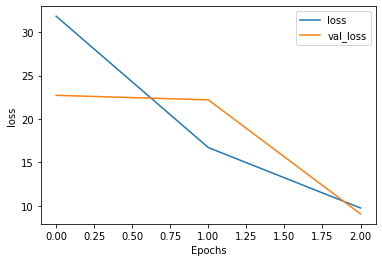

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 874us/sample - loss: 7.8151
Epoch 2/3
708/708 [==============================] - 1s 864us/sample - loss: 6.4417
Epoch 3/3
708/708 [==============================] - 1s 849us/sample - loss: 5.4976
loss cuts = tf.Tensor(
[1.978183  1.9654402 1.9768522 1.9991359 1.9939401 2.0220928 1.9974686
 2.0170083 1.9284202 1.9570761 2.022139  2.0653725 2.1038926 1.9498761
 1.9189504 1.926235  1.9136121 1.8903803 1.993799  1.9602671], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.3725283, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.9114398 1.8796287 1.8793746 1.9225272 1.9245085 1.951541  1.9560971
 1.9490604 1.9209024 1.9527454 1.9562213 1.9919745 2.022754  1.8843815
 1.8675605 1.8558784 1.832294  1.8030372 1.9728458 1.9500178], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.319629, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.9812475 1.9523927 1.9551227 1.9884365 1.9908928 2.0166738 2.0114539
 2

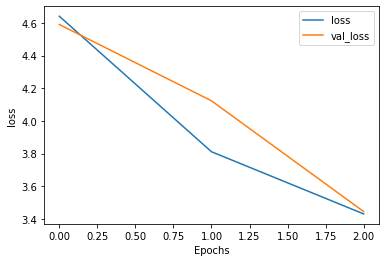

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 879us/sample - loss: 2.7357
Epoch 2/3
708/708 [==============================] - 1s 883us/sample - loss: 2.3382
Epoch 3/3
708/708 [==============================] - 1s 858us/sample - loss: 2.0271
loss cuts = tf.Tensor(
[1.833277  1.8164443 1.8195981 1.8465414 1.8422176 1.8890138 1.8746283
 1.8581197 1.8310864 1.8638247 1.8775396 1.9166152 1.9362819 1.8277496
 1.8600912 1.8029771 1.8150753 1.7127017 1.8958552 1.8754579], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(0.82084095, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.8614578 1.8432163 1.8470646 1.8731834 1.866882  1.925935  1.9071927
 1.8882692 1.8564364 1.8949156 1.9091564 1.9562588 1.9814336 1.8502638
 1.8927429 1.8192254 1.8332876 1.692716  1.9259055 1.8993031], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(0.8306564, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.8754745 1.8538697 1.8587732 1.8878919 1.8825425 1.9502414 1.927713
 

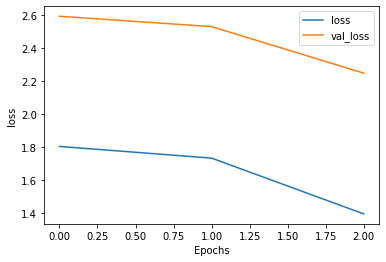

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 879us/sample - loss: 0.9951
Epoch 2/3
708/708 [==============================] - 1s 859us/sample - loss: 0.9034
Epoch 3/3
708/708 [==============================] - 1s 867us/sample - loss: 0.8144
loss cuts = tf.Tensor(
[1.7651939 1.7856295 1.7504437 1.8437109 1.8386761 1.8745682 1.8316212
 1.8300697 1.7395284 1.8150709 1.85924   1.9436917 1.9713026 1.7138425
 1.5212907 1.388096  1.3956687 1.2206333 1.7642086 1.6554842], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.8286469, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.8835568 1.9017661 1.8747096 1.9632012 1.9668851 1.9929858 1.9528174
 1.9570037 1.8642637 1.9425944 1.9931524 2.0582886 2.079433  1.8619915
 1.6820709 1.5448678 1.5454473 1.3797543 1.9002787 1.7936208], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.6865793, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.9185734 1.9399809 1.9118797 2.0036185 2.0112836 2.0355809 1.9927322
 

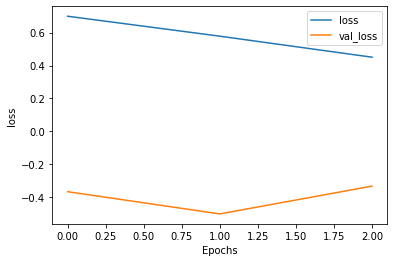

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 903us/sample - loss: 0.3323
Epoch 2/3
708/708 [==============================] - 1s 874us/sample - loss: 0.1766
Epoch 3/3
708/708 [==============================] - 1s 859us/sample - loss: 0.0912
loss cuts = tf.Tensor(
[1.7478817 1.8344272 1.8731533 1.8620708 1.9235725 1.9357111 1.8742137
 1.8001034 1.6013741 1.7325034 1.9797897 2.036993  2.0750546 1.5882168
 1.5767853 1.5165362 1.5366006 1.3479794 1.8078682 1.6299852], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.699155, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.669293  1.7555778 1.8038038 1.7848485 1.8409584 1.8555267 1.7871355
 1.7134813 1.5242255 1.6426888 1.9165627 1.9798613 2.0158355 1.4789665
 1.4820448 1.38393   1.4228159 1.1921712 1.7141163 1.5415577], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.7447593, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.6510025 1.7159437 1.7649914 1.7444439 1.7818042 1.8082602 1.7370981
 1

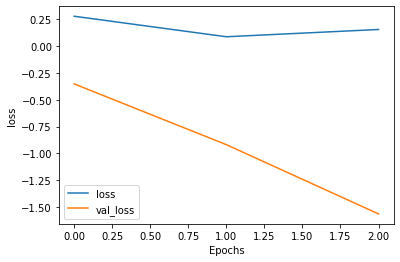

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 889us/sample - loss: -0.0856
Epoch 2/3
708/708 [==============================] - 1s 887us/sample - loss: 0.0328
Epoch 3/3
708/708 [==============================] - 1s 879us/sample - loss: 0.0651
loss cuts = tf.Tensor(
[1.5994459 1.4198717 1.4619933 1.518891  1.5308526 1.5235524 1.4115981
 1.436963  1.3095669 1.4216708 1.647417  1.7662176 1.8549013 1.3981638
 1.344557  1.2451218 1.2810383 1.1121813 1.290644  1.3734317], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.5949472, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.61429   1.44807   1.4885075 1.542903  1.558624  1.546601  1.4470513
 1.4665617 1.3496842 1.4510993 1.6617912 1.765741  1.8415176 1.4345659
 1.3808331 1.3065792 1.3359494 1.1930424 1.3439808 1.4092287], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.4886585, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.6154784 1.4700472 1.5101606 1.5509423 1.5712512 1.5541327 1.4687948


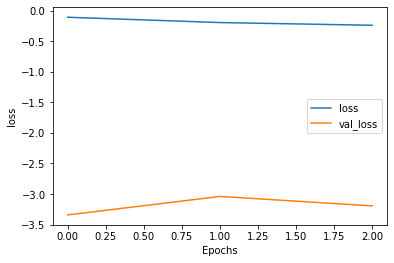

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 898us/sample - loss: -0.3090
Epoch 2/3
708/708 [==============================] - 1s 871us/sample - loss: -0.2746
Epoch 3/3
708/708 [==============================] - 1s 857us/sample - loss: -0.2265
loss cuts = tf.Tensor(
[1.5723054 1.5108178 1.4988152 1.3441207 1.306812  1.2751504 1.2771152
 1.2671878 1.224604  1.2468369 1.307125  1.363235  1.362637  1.2433164
 1.2831709 1.1927776 1.2004287 1.1668798 1.2572918 1.3021886], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(0.95432645, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.6617696 1.5973696 1.5873401 1.4156888 1.3723369 1.3390719 1.347216
 1.3370011 1.2910123 1.3203105 1.3905367 1.4499568 1.4362723 1.3229377
 1.3605235 1.2579948 1.2624897 1.2222171 1.3097978 1.3654704], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(0.9633641, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.6504387 1.591561  1.5777882 1.4172182 1.3752335 1.3431491 1.351596

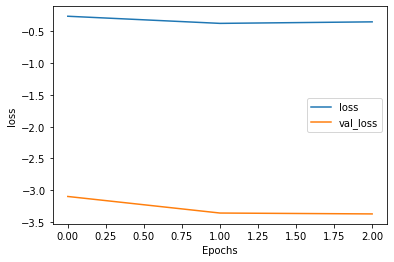

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 896us/sample - loss: -0.3403
Epoch 2/3
708/708 [==============================] - 1s 868us/sample - loss: -0.4449
Epoch 3/3
708/708 [==============================] - 1s 860us/sample - loss: -0.3905
loss cuts = tf.Tensor(
[1.4504317 1.4222237 1.5249078 1.3705121 1.3574593 1.3186784 1.3586768
 1.331193  1.2971064 1.3302249 1.3170314 1.3281286 1.3522916 1.410064
 1.4083692 1.3410361 1.293711  1.2537944 1.3140491 1.2901924], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(9.827089, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.454711  1.435235  1.5562644 1.4027851 1.3927245 1.3472519 1.3936963
 1.3579748 1.3159399 1.3571897 1.3381155 1.3478508 1.374882  1.4609494
 1.4504282 1.3708541 1.3134542 1.2736845 1.337209  1.3046587], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(9.760659, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.4587939 1.4371598 1.5380533 1.396723  1.3889772 1.3431609 1.3939555
 

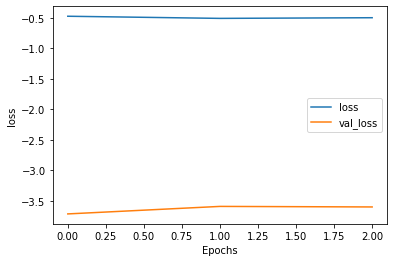

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 876us/sample - loss: -0.5536
Epoch 2/3
708/708 [==============================] - 1s 870us/sample - loss: -0.5709
Epoch 3/3
708/708 [==============================] - 1s 855us/sample - loss: -0.6067
loss cuts = tf.Tensor(
[1.3238244 1.347101  1.3846353 1.3317397 1.299126  1.2827574 1.268118
 1.2496312 1.2298119 1.2463249 1.3086869 1.3413572 1.3357912 1.3956015
 1.3100045 1.288288  1.2944748 1.273472  1.2732649 1.2558854], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.24052, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.3003572 1.3155113 1.3619894 1.3019727 1.2720541 1.2533703 1.2379576
 1.2159635 1.1915872 1.2121543 1.2868706 1.3316225 1.3179541 1.3815674
 1.2837878 1.256908  1.2647214 1.2485101 1.2431282 1.2210116], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.1547143, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.2743642 1.2728794 1.3402209 1.253729  1.2210528 1.1985589 1.1784363
 

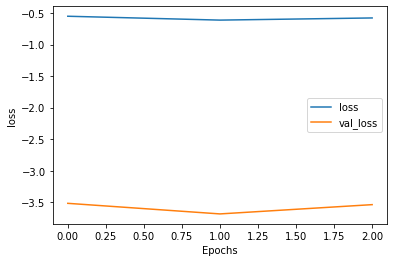

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 872us/sample - loss: -0.6439
Epoch 2/3
708/708 [==============================] - 1s 866us/sample - loss: -0.7012
Epoch 3/3
708/708 [==============================] - 1s 868us/sample - loss: -0.7033
loss cuts = tf.Tensor(
[1.1478903 1.1643549 1.2760535 1.150993  1.1553053 1.1093262 1.1144953
 1.0940372 1.0540098 1.0737711 1.1027532 1.1825432 1.1415768 1.1690009
 1.1253524 1.0841197 1.0998653 1.0735629 1.0485077 1.0245624], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.1648085, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.1028713  1.1220201  1.2615291  1.1034036  1.1056844  1.0577866
 1.0642517  1.0440638  1.0021001  1.0244497  1.0546756  1.147497
 1.098365   1.129823   1.0792856  1.0323969  1.0458633  1.0165541
 0.99596107 0.9722663 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.2289127, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.0706624  1.0913405  1.2339393  1.0671651  1.07207

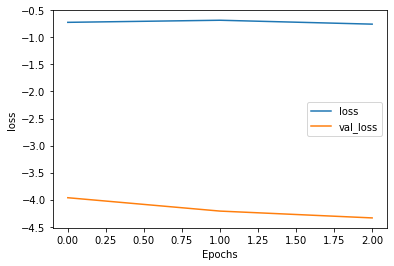

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 880us/sample - loss: -0.8162
Epoch 2/3
708/708 [==============================] - 1s 865us/sample - loss: -0.7608
Epoch 3/3
708/708 [==============================] - 1s 854us/sample - loss: -0.6738
loss cuts = tf.Tensor(
[0.9644731  0.9569723  1.0055257  0.93266016 0.90066683 0.8939445
 0.87771785 0.8695304  0.8429549  0.84140986 0.9045213  0.9381389
 0.87562656 0.9179113  0.89922535 0.887677   0.8575787  0.8573182
 0.8201864  0.7846919 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.2147021, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.0600761  1.0511901  1.0848312  1.0352124  1.010633   1.0055723
 0.9948774  0.9895174  0.9685118  0.9652001  1.0123852  1.0371047
 0.99186796 1.0193937  1.0080483  0.9952174  0.9718567  0.96553755
 0.95036095 0.919415  ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.5733228, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.1101507  1.1018494  1.1325574

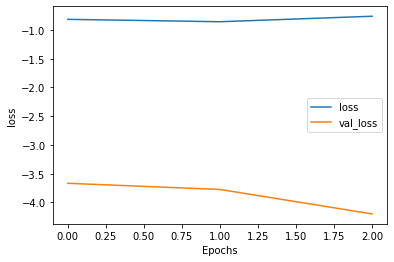

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 891us/sample - loss: -0.8627
Epoch 2/3
708/708 [==============================] - 1s 907us/sample - loss: -0.9237
Epoch 3/3
708/708 [==============================] - 1s 856us/sample - loss: -0.9452
loss cuts = tf.Tensor(
[0.97300565 1.0432719  1.0768104  0.95016825 0.9561416  0.90756416
 0.8960743  0.9280349  0.90448767 0.909449   1.0204167  1.0367236
 0.91426075 1.0215366  0.97708523 0.9356381  0.94611466 0.87962055
 0.90372413 0.83352697], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(7.06021, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.004606   1.075458   1.1104164  0.9812768  0.9878778  0.9384828
 0.92618513 0.95803326 0.93459684 0.93741083 1.0520606  1.0684091
 0.9431225  1.0497376  1.0052803  0.96242267 0.9729567  0.90080297
 0.9291811  0.8592892 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(7.232911, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.0477514  1.1129179  1.1476426 

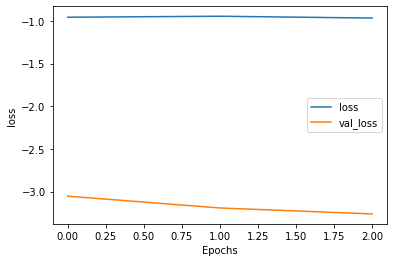

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 870us/sample - loss: -1.0933
Epoch 2/3
708/708 [==============================] - 1s 863us/sample - loss: -0.9453
Epoch 3/3
708/708 [==============================] - 1s 863us/sample - loss: -0.9151
loss cuts = tf.Tensor(
[0.9719256  1.0597483  1.115932   0.97618246 0.96582377 0.92368925
 0.8849077  0.91699946 0.92279077 0.903913   1.0795985  1.0532562
 0.9259672  0.94853187 0.8988923  0.93578696 0.95420015 0.89505744
 0.84238553 0.82278824], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.2615654, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.9500869  1.0466013  1.0998602  0.9521655  0.9405023  0.89964426
 0.8588551  0.88937587 0.901204   0.87954855 1.0604204  1.0317593
 0.89866143 0.9277742  0.8823918  0.91594106 0.9300862  0.87216926
 0.82139486 0.8012566 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.123523, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.9958643  1.0828412  1.13366

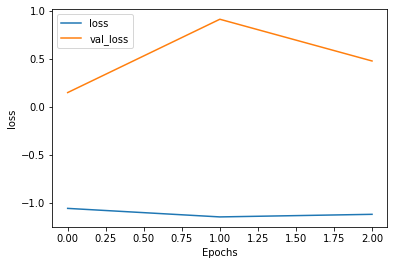

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 880us/sample - loss: -1.1153
Epoch 2/3
708/708 [==============================] - 1s 859us/sample - loss: -1.1025
Epoch 3/3
708/708 [==============================] - 1s 847us/sample - loss: -1.1938
loss cuts = tf.Tensor(
[0.77848893 0.8677033  0.8366651  0.825164   0.763018   0.68955
 0.66735107 0.7020622  0.7065748  0.68491405 0.83165395 0.80905616
 0.67333394 0.76708144 0.7293758  0.6470983  0.69704485 0.677138
 0.63145417 0.6406512 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(24.436047, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.897318   0.99846095 0.9646005  0.94867027 0.87481236 0.784352
 0.7561262  0.80165327 0.803463   0.77474517 0.9542798  0.92942184
 0.7617215  0.87609226 0.8300905  0.7336282  0.7975197  0.77377695
 0.70757526 0.7212907 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(20.69728, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.80832434 0.918692   0.8839582  0

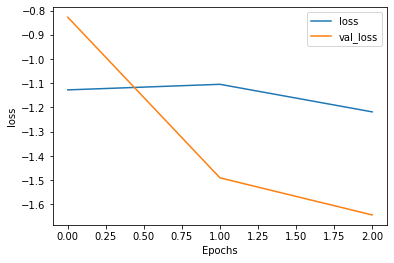

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 888us/sample - loss: 17.4091
Epoch 2/3
708/708 [==============================] - 1s 864us/sample - loss: 35.7313
Epoch 3/3
708/708 [==============================] - 1s 858us/sample - loss: 25.1530
loss cuts = tf.Tensor(
[0.6019864  0.7345252  0.76328015 0.61297476 0.6133928  0.5605089
 0.5628046  0.64832664 0.6017394  0.5822002  0.70224875 0.6583127
 0.5575491  0.68817246 0.6591406  0.5858328  0.7574621  0.54123455
 0.52278787 0.4780397 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(9.508413, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.6295989  0.7508927  0.77064174 0.62427944 0.6235939  0.5688627
 0.57564557 0.66445684 0.614089   0.59244156 0.7157836  0.6739601
 0.56965286 0.7029049  0.6705308  0.5914408  0.762076   0.5344118
 0.5382943  0.49239755], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(8.930559, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.6211066  0.74212265 0.7618827  

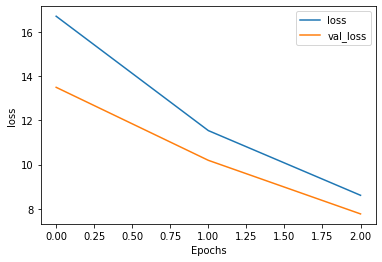

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 888us/sample - loss: 7.0037
Epoch 2/3
708/708 [==============================] - 1s 858us/sample - loss: 5.9906
Epoch 3/3
708/708 [==============================] - 1s 870us/sample - loss: 5.2471
loss cuts = tf.Tensor(
[0.62222666 0.68037605 0.6387431  0.5711289  0.58662516 0.50897425
 0.5175974  0.61857134 0.539993   0.58269167 0.93020636 0.7111031
 0.5213931  0.77247965 0.55004656 0.5605866  0.53427434 0.43794
 0.46694806 0.4814963 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.8934941, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.5829209  0.6519196  0.60650325 0.5386177  0.55495065 0.4768607
 0.48378724 0.58555615 0.50581074 0.54938376 0.88374585 0.6719457
 0.48925483 0.7433408  0.5178215  0.5311059  0.5039586  0.41208255
 0.4228363  0.444964  ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.8689392, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.5335368  0.6077064  0.55948484 0.

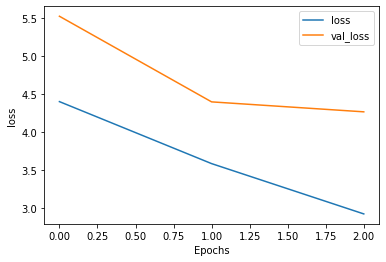

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 886us/sample - loss: 2.5125
Epoch 2/3
708/708 [==============================] - 1s 873us/sample - loss: 2.1550
Epoch 3/3
708/708 [==============================] - 1s 858us/sample - loss: 1.8824
loss cuts = tf.Tensor(
[0.38503343 0.45881867 0.45882344 0.4024359  0.3713082  0.28502727
 0.29908574 0.34737659 0.31654721 0.3407207  0.44181645 0.45554227
 0.2992652  0.6765479  0.38226193 0.3235517  0.27200413 0.18140388
 0.25782794 0.2657562 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.737556, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.39502993 0.46749777 0.4673955  0.411627   0.38146713 0.29601797
 0.3097853  0.35742667 0.32722548 0.35065424 0.45197845 0.4658551
 0.30899352 0.69283825 0.39149725 0.33334336 0.28326347 0.19500127
 0.2678617  0.2762227 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.4954402, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.3664546  0.44010442 0.4405918

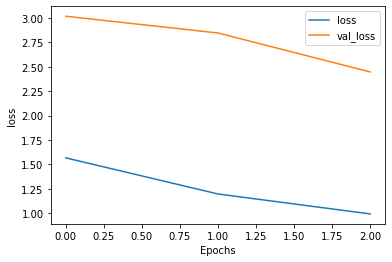

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 875us/sample - loss: 0.7527
Epoch 2/3
708/708 [==============================] - 1s 850us/sample - loss: 0.7099
Epoch 3/3
708/708 [==============================] - 1s 854us/sample - loss: 0.5143
loss cuts = tf.Tensor(
[ 0.2900442   0.30138206  0.2860602   0.35215586  0.14527526  0.08271303
  0.03739943  0.10850552 -0.05538212 -0.02107078  0.24639991  0.10838429
  0.31667304 -0.07073003  0.06742921 -0.22340922 -0.22437291 -0.16507642
  0.8774806   0.173192  ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(9.926966, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[ 0.3068611   0.3214418   0.30803102  0.36760104  0.16031905  0.09323242
  0.04962842  0.1231844  -0.03944166 -0.00601593  0.26916695  0.1342019
  0.32845396 -0.05217613  0.08563812 -0.20922942 -0.2087834  -0.15758146
  0.9262234   0.1858975 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(9.743608, shape=(), dtype=float32)
loss cuts = tf.T

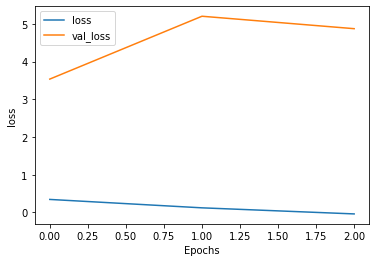

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 872us/sample - loss: 0.0546
Epoch 2/3
708/708 [==============================] - 1s 886us/sample - loss: -0.1046
Epoch 3/3
708/708 [==============================] - 1s 888us/sample - loss: -0.2578
loss cuts = tf.Tensor(
[-0.37889808 -0.3554759  -0.3862064  -0.14770262 -0.2423609  -0.29268557
 -0.33068734 -0.05515485 -0.1039073  -0.08189332 -0.02879439 -0.0634322
 -0.07770477 -0.03400014 -0.0961556  -0.12955715 -0.18983941 -0.08115965
 -0.23293938 -0.15231656], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(4.2964945, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[-0.40491003 -0.38296634 -0.4132343  -0.17339526 -0.26945412 -0.31966197
 -0.3570286  -0.07560982 -0.1212949  -0.10054524 -0.04610117 -0.07893652
 -0.09269579 -0.05436501 -0.11228618 -0.14608578 -0.20514067 -0.09731936
 -0.24376704 -0.16644563], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(4.2560163, shape=(), dtype=float32)
loss cuts = 

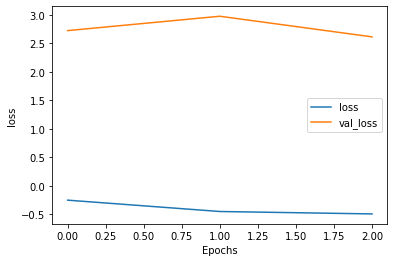

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 888us/sample - loss: -0.5843
Epoch 2/3
708/708 [==============================] - 1s 872us/sample - loss: -0.5636
Epoch 3/3
708/708 [==============================] - 1s 849us/sample - loss: -0.7167
loss cuts = tf.Tensor(
[-0.26436698 -0.22282241 -0.2920136  -0.23551159 -0.28496176 -0.27860987
 -0.3077798  -0.26608694 -0.29347718 -0.34292537 -0.3669241  -0.22466122
 -0.27028418 -0.31969827 -0.3037871  -0.36649507 -0.3416745  -0.28572303
 -0.24262021 -0.40549463], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(4.0952625, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[-0.2533266  -0.21192272 -0.27751797 -0.22327365 -0.272627   -0.2655391
 -0.2940898  -0.25342733 -0.28094095 -0.33067346 -0.35788494 -0.21263506
 -0.25670987 -0.29390234 -0.2902121  -0.35306495 -0.32928568 -0.21172993
 -0.20330895 -0.391132  ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(4.242086, shape=(), dtype=float32)
loss cuts = 

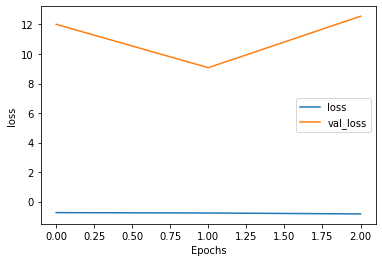

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 883us/sample - loss: -0.8141
Epoch 2/3
708/708 [==============================] - 1s 862us/sample - loss: -0.8967
Epoch 3/3
708/708 [==============================] - 1s 846us/sample - loss: -0.9308
loss cuts = tf.Tensor(
[-0.33434403 -0.19945322 -0.23422824 -0.17188106  0.25204813  0.11370176
  0.04690403 -0.0139709  -0.00829025  0.00207137  0.01673358  0.02541582
 -0.07778026  0.05555367 -0.15332143 -0.24085186 -0.2507571  -0.27193284
 -0.3546695  -0.328677  ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.4232829, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[-0.3346548  -0.19689421 -0.23053752 -0.17012037  0.25352666  0.13026382
  0.06390803  0.00378772  0.00932917  0.01991024  0.03569027  0.04442387
 -0.05859174  0.07188614 -0.14754088 -0.22565056 -0.24520592 -0.2677732
 -0.3517142  -0.32742018], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.2353714, shape=(), dtype=float32)
loss cuts =

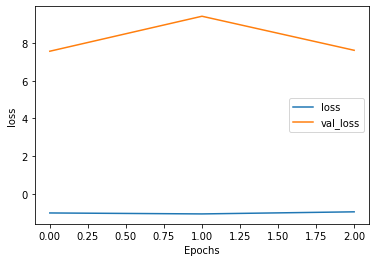

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 907us/sample - loss: -0.6283
Epoch 2/3
708/708 [==============================] - 1s 890us/sample - loss: -1.0624
Epoch 3/3
708/708 [==============================] - 1s 868us/sample - loss: -1.1959
loss cuts = tf.Tensor(
[-0.37474078 -0.255495   -0.29867524 -0.4337498  -0.09140284 -0.11875796
 -0.12213655 -0.24444245 -0.19506519 -0.18222405 -0.144349    0.00092906
 -0.21584125 -0.24441363 -0.41075778 -0.2137808  -0.23350124 -0.0156707
 -0.20036714 -0.29990393], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.8753052, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[-0.3980442  -0.28121915 -0.32299447 -0.45175704 -0.11932075 -0.13906267
 -0.14107344 -0.27005002 -0.21766979 -0.20417365 -0.1644617  -0.02084137
 -0.24010989 -0.2699143  -0.43209484 -0.24598518 -0.26828042 -0.08588947
 -0.23536044 -0.32825825], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.5349724, shape=(), dtype=float32)
loss cuts =

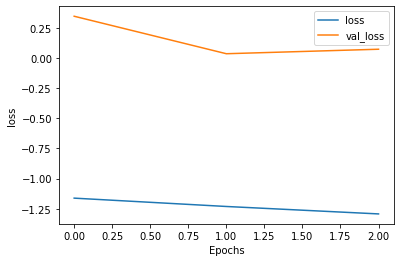

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 881us/sample - loss: -1.2436
Epoch 2/3
708/708 [==============================] - 1s 909us/sample - loss: -1.2675
Epoch 3/3
708/708 [==============================] - 1s 878us/sample - loss: -1.1363
loss cuts = tf.Tensor(
[-0.35580802 -0.28461444 -0.2864223  -0.46105283 -0.1513092  -0.2161199
 -0.26044744 -0.2628886  -0.25297296 -0.23180853 -0.28980404 -0.31476557
 -0.28470278 -0.38021106 -0.40506297 -0.16316573 -0.09831999 -0.15409084
 -0.2383901  -0.30858928], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(5.2319183, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[-0.39333248 -0.32332367 -0.32191527 -0.503229   -0.1987362  -0.2573411
 -0.29904282 -0.30039036 -0.2905516  -0.2705074  -0.32683116 -0.35197568
 -0.3192892  -0.42067432 -0.4419796  -0.21667694 -0.15241279 -0.20551397
 -0.28502238 -0.35370195], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(5.5881286, shape=(), dtype=float32)
loss cuts = 

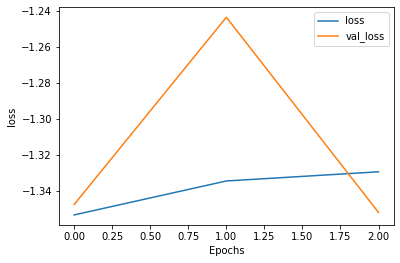

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 876us/sample - loss: -1.4721
Epoch 2/3
708/708 [==============================] - 1s 867us/sample - loss: -1.3880
Epoch 3/3
708/708 [==============================] - 1s 863us/sample - loss: -1.3061
loss cuts = tf.Tensor(
[-0.28698283 -0.30721533 -0.27160656 -0.4355762  -0.11100852  0.07246079
  0.03679109  0.07138631 -0.1125793  -0.11290163 -0.24148731 -0.21465252
 -0.31256843 -0.33581924 -0.2872662  -0.05909444 -0.07733554  0.01035605
  0.07528172 -0.02671254], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.460031, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[-0.23207287 -0.24835016 -0.20585705 -0.36268878 -0.03409296  0.15740241
  0.11368955  0.14268424 -0.0402472  -0.04365386 -0.17039339 -0.14588375
 -0.23964278 -0.26296294 -0.21756385  0.01069567 -0.00994805  0.07974606
  0.15048334  0.04135637], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.4519787, shape=(), dtype=float32)
loss cuts =

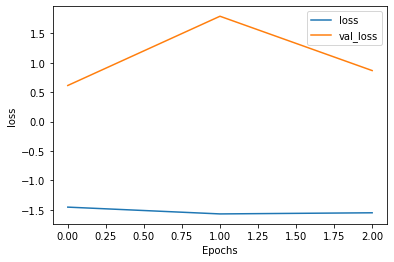

Train on 708 samples
Epoch 1/3
708/708 [==============================] - 1s 871us/sample - loss: -0.6507
Epoch 2/3
708/708 [==============================] - 1s 874us/sample - loss: -1.0475
Epoch 3/3
708/708 [==============================] - 1s 866us/sample - loss: -1.4721
loss cuts = tf.Tensor(
[0.04052811 0.0343816  0.14063117 0.1291059  0.2725687  0.22385031
 0.09485371], shape=(7,), dtype=float32)
model2 loss = tf.Tensor(2.253504, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.10703007 0.0916018  0.19728196 0.18620417 0.33345932 0.2782346
 0.14077479], shape=(7,), dtype=float32)
model2 loss = tf.Tensor(2.1111379, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.15312904 0.13535458 0.24296957 0.23226014 0.38530537 0.32753116
 0.18518372], shape=(7,), dtype=float32)
model2 loss = tf.Tensor(2.1749969, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.17558056 0.16061158 0.26744062 0.25558126 0.40756455 0.35166875
 0.2109083 ], shape=(7,), dtype=float32)
model2 loss = tf.Tenso

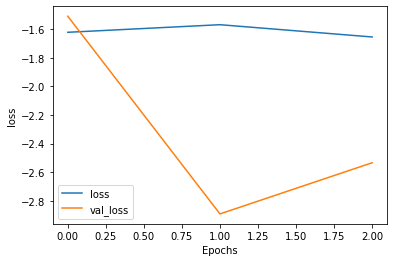

학습 종료.......
2020-06-15:10:58:14


In [16]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

print("학습 시작")
print(datetime.now().strftime("%Y-%m-%d:%H:%M:%S"))
while True:

    gc.collect()
    

    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)

    # 전체 train, test dataset 생성
    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    
    # the model1 training dataset
    train_x = train_x[:train_end_back]
    train_y = train_y[:train_end_back]

    # train, validation set 분리하여 train1은 예측모델로 train2는 손절값 학습 모델로 사용
    train1_x, train2_x, train1_y, train2_y = train_test_split(train_x, train_y, test_size=0.4)
    
    # test set 생성
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)
    test_y_target = np.expand_dims(test_y[:, :, 3], axis=2)    
    
    # the model1 training
    train1_y_target = np.expand_dims(train1_y[:, :, 3], axis=2)    
    early_stopping1 = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1)
    model1.load_weights(checkpoint_path)
    model1.fit(train1_x, train1_y_target, batch_size=batch_size, epochs=3)#, callbacks=[early_stopping1], validation_data=(test_x, test_y_target))
    model1.save_weights(checkpoint_path)
    
    
    # the model2 test input 생성
    preds = tf.cast(model1(test_x), dtype=tf.float64)
    targets = test_y_target.copy()
    targets[:, -max(1, int(future_day/time_interval)):, :] = 0    
    test_x_m2 = tf.concat([preds, targets], 2)
    
    # the model2 training
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)    
    early_stopping2 = learn.EarlyStopping(patience=2, verbose=1)
    iter = epochs
    basic_epochs = tf.cast(epochs / 5, dtype=tf.int32)
    for iteration in range(iter):
        batch_input, batch_output = learn.next_random_serial_batch(train2_x, train2_y, batch_size)

        gradients2 = gradient2(model1, model2, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
        if iteration % 100 == 0:

            # model2의 test output 생성
            loss_cuts = tf.reshape(model2(test_x_m2)[:, -1, 0], [-1])
            print('loss cuts =', loss_cuts)       

            # model2의 test loss
            loss2 = loss_fn_model2(model1, model2, test_x, test_y)
            print('model2 loss =', loss2)  


        if iteration > iter / 2 and early_stopping2.validate(loss2)==True:
            break    

    if iter > basic_epochs: iter -= basic_epochs
    if iter < basic_epochs: iter = basic_epochs
    
    
    # 다시 전체 데이터셋 예측 모델로 학습    
    train_y_target = np.expand_dims(train_y[:, :, 3], axis=2)        
    model1.load_weights(checkpoint_path)
    history = model1.fit(train_x, train_y_target, batch_size=batch_size, epochs=3, callbacks=[early_stopping1], validation_data=(test_x, test_y_target))
    model1.save_weights(checkpoint_path)
        
    print('test dates ' + current_test_start + "~" + current_test_end)

    # prediction1 accuracy
    updown = np.sign(test_y[:, -1, 3]).reshape((-1))
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('prediction1 accuracy = ', accu)

    # reinforced prediction2
    preds = tf.cast(model1(test_x), dtype=tf.float64)
    test_x_m2 = tf.concat([preds, targets], 2)
    prediction2 = tf.reshape(model2(test_x_m2)[:, -1, 0], [-1])    
    print('prediction2 = ', prediction2)

    # loss graph
    plot_graphs(history, 'loss')

    test_prediction1.append(prediction1)
    test_prediction2.append(prediction2)

    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_train_start = df.loc[prepro.date_to_index(df, current_train_end) - 2000, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']
print("학습 종료.......")
print(datetime.now().strftime("%Y-%m-%d:%H:%M:%S"))

In [17]:
t1 = np.concatenate(test_prediction1)
t2 = np.concatenate(test_prediction2)

In [18]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴 - 종가를 test base price로 하는 경우
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)


# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [19]:
updown = np.sign(test_y[:, -1, 3]).reshape((-1))
#calculate accuracy
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('accuracy = ', accu)

accuracy =  tf.Tensor(0.946611909650924, shape=(), dtype=float64)


In [20]:
updown.shape

(487,)

In [21]:
#train_base_prices = train_base_prices[:batch_size]
#train_prediction = train_prediction[:batch_size]
#train_y = train_y[:batch_size]

In [22]:
result = GenerateResult(t1, t2, test_y[:, -1, 3].reshape(-1), test_dates, n_timestep, future_day, train_end_back, trans_day)

In [23]:
test_start_index = prepro.date_to_index(df, test_start)
test_end_index = prepro.date_to_index(df, test_end)
test_open_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '시가']))
test_high_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '고가']))
test_low_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '저가']))

In [24]:
#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)
# 손익 계산
profits = np.zeros(len(test_dates))
for i in range(len(test_dates)):
    if result.test_predict_price[i]-test_open_prices[i] > 0:
        profits[i] = result.test_output_price[i] - test_open_prices[i]
    else:
        profits[i] = test_open_prices[i] - result.test_output_price[i]
# 손절 손익 계산
profits2 = np.zeros(len(test_dates))
for i in range(len(test_dates)):
    if t2[i] <= 0: profits2[i] = profits[i]
    else:
        if result.test_predict_price[i] - test_open_prices[i] > 0:
            if test_open_prices[i] - test_low_prices[i] > t2[i]:
                profits2[i] = -t2[i]
            else:
                profits2[i] = profits[i]
        else:
            if test_high_prices[i] - test_open_prices[i] > t2[i]:
                profits2[i] = -t2[i]
            else:
                profits2[i] = profits[i]

info : loss_cut-3-test_kospi200f_809_0515_06-15:10:58_240_0.489
MSE : 288.6857 , Accuracy : 0.489
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/loss_cut-3-test_kospi200f_809_0515_06-15:10:58_240_0.489/assets


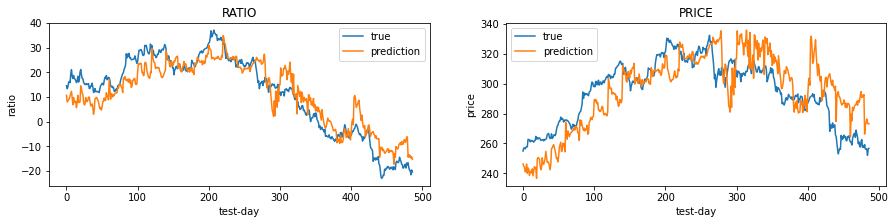

In [25]:
preds = np.array(result.test_predict_price) - np.array(test_open_prices)
trues = np.array(result.test_output_price) - np.array(test_open_prices)
result.evaluation(preds, trues)
result.table(test_open_prices, test_high_prices, test_low_prices, profits, profits2)
result.save_result(model_name,item_name,n_unit,target_type,batch_size,n_timestep,time_interval,epochs,str(alpha),comment)
result.save_visualization()
result.save_model(model2)

In [26]:
"""
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)


gc.collect()

train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                       current_train_start, current_train_end,
                                                       current_test_start, current_test_end,
                                                       future_day, n_timestep, time_interval)

# input_size, columns reset
input_size = len(df.columns) - len(remove_columns)
input_columns = df.columns.copy()

train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

#model.compile(optimizer='adam',
#          loss=loss_fn)
#          #callbacks=[cp-callback]
#          #metrics=['accuracy'])

# the firs training dataset
train_x = train_x[:-future_day]
train_y = train_y[:-future_day]    

#global_step = tf.train.get_or_create_global_step()
global_step = tf.Variable(0, trainable=False)
#lr_decay = tf.train.exponential_decay(learning_rate, global_step,
#                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
epochs = len(train_y)
for iteration in range(399):
    batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)

    #noise = 2*np.random.randn(batch_size,n_timestep,1)
    #batch_output = batch_output+noise
    #batch_input = encoder(train_input[idx])
    gradients1 = gradient1(model1, model2, batch_input, batch_output)
    optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(model1(train_x, training=False)[:, -1, 0], [-1])
    
    n = len(targets)    
    returns = [1.0]
    losses = []
    for i in range(n - 1):
       
        # average_return, std of returns, remaining days, preds[0] 
        state = []
        
        random_rates = []
        for k in range(i+1):
            random_rates.append(rates[k])
        # 실재 수익률을 기반으로 random 수익률 생성, 예측에 의한 porfits 생성 
        for k in range(i+1, n):
            random_rates.append(tf.random.normal((), mean=targets[k] / 100, stddev=0.1, dtype=tf.float64))
        profits = tf.convert_to_tensor(random_rates, dtype=tf.float64)*tf.cast(preds, dtype=tf.float64) + 1
        
        # 현재까지의 예측에 의한 수익률 기하평균 구하기
        returns_past = []
        for k in range(i+1):
            returns_past.append(profits[k])
        avg_return = tf.cast(tf.math.reduce_prod(returns_past)**(1/(i+1)), dtype=tf.float64)
        
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))
     
        # 목표일까지의 기대 기하 평균 수익률 구하기 
        returns_future = []
        for j in range(i+1, n):
            returns_future.append(profits[j])
        avg_return_future = tf.math.reduce_prod(returns_future)**(1/(n-i-1))

        # 예측 기하 평균 수익률과 기대 기하 평균 수익률의 MSE
        value = tf.cast(model2(state, training=True)[0, 0], dtype=tf.float64)
        losses.append((value - avg_return_future)**2)
        if n == 3: break
    print("losses", losses)
    print("value", value)    
    with tf.GradientTape() as tape:
        gradients2 = tape.gradient(tf.math.reduce_sum(losses), model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
    

    
    if iteration % 100 == 0:
        #test_MSE = model.evaluate(test_x, test_y)
        prediction = model1.predict(test_x)
        prediction_MSE = sum((updown - np.sign(prediction[:, -1, 0]).reshape(-1))**2)/len(test_y)
        print('prediction_MSE =', prediction_MSE)

    if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
        break
epochs -= epochs / 5
if epochs <= 0: epochs = 100
"""

'\ncurrent_train_start = df.loc[prepro.date_to_index(df, train_start), \'date\']\ncurrent_train_end = df.loc[prepro.date_to_index(df, train_end), \'date\']\ncurrent_test_start = df.loc[prepro.date_to_index(df, test_start), \'date\']\ncurrent_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, \'date\']\n\n\n#  각 transfer 구간의 예측값들을 합치기 위하여\ntest_prediction1 = []\ntest_prediction2 = []\ntest_target = []\n\n# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)\nearly_stopping = learn.EarlyStopping(patience=2, verbose=1)\n\n\ngc.collect()\n\ntrain_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, \n                                                       current_train_start, current_train_end,\n                                                       current_test_start, current_test_end,\n                                                       future_day, n_timestep, time_interval)\n\n# input_size, columns reset\ninput_size 